# Setup

In [32]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png"))
options(jupyter.plot_scale = 1.5)
options(warn = -1)
require("pacman")
pacman::p_load(tidyverse, ggplot2, latex2exp, fpp2, 
               ggfortify, ggpubr, zoo, lubridate, mgcv,
               aod, tseries, xts, vars)

source('../Scripts/ReadData.R')
source('../Scripts/ModelSelection.R')
source('../Scripts/ResidualAnalysis.R')
source('../Scripts/Forecasting.R')

# Creating Merged Time Series

,homeownership,price,gdp,interest
homeownership,1.000000000,-0.15755238,-0.5682467,-0.004818895
price,-0.157552378,1.00000000,0.2475899,0.041538017
gdp,-0.568246742,0.24758992,1.0000000,0.175492309
interest,-0.004818895,0.04153802,0.1754923,1.000000000


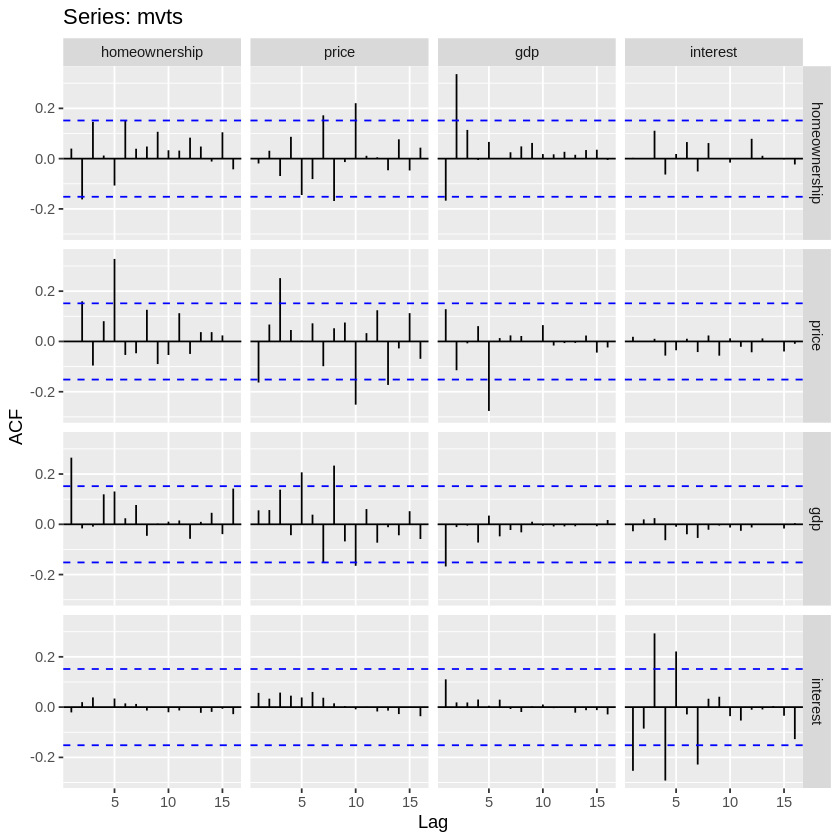

In [22]:
homeownership_raw <- read_homeownership()
homeownership <- homeownership_raw %>% mutate(Value = c(NA, diff(Value))) %>% drop_na
price <- read_sales_price() %>% mutate(Price = c(NA, diff(Price))) %>% drop_na
gdp <- read_gdp() %>% mutate(GDP = c(NA, diff(GDP))) %>% drop_na
interest <- read_interest_rate() %>% mutate(Rate = c(NA, diff(Rate))) %>% drop_na

homeownership <- xts(x = homeownership$Value, order.by = homeownership$Date)
price <- xts(x = price$Price, order.by = price$Date)
gdp <- xts(x = gdp$GDP, order.by = gdp$Date)
interest <- xts(x = interest$Rate, order.by = interest$Date)
breaks <- head(endpoints(interest, 'quarters')+1, -1)
interest <- period.apply(interest, breaks, mean)

mvts <- merge(homeownership, price, join = 'inner') %>%
        merge(gdp, join = 'inner') %>%
        merge(interest, join = 'inner')

cor(mvts)
ggAcf(mvts)

# VAR Modelling

## Creating VAR Model

In [3]:
test_split <- 4
train <- head(mvts, -test_split)
test <- tail(mvts, test_split)

In [4]:
var_orders <- VARselect(train, lag.max = 20)$selection %>% as.data.frame
var_orders
var_model <- VAR(mvts, p = var_orders[1,1])

n_terms <- var_model$K * var_model$p

ho_vcov <- vcov(var_model$varresult$homeownership)
ho_vcov <- ho_vcov[-nrow(ho_vcov), -ncol(ho_vcov)]
ho_eq_coeff <- coefficients(var_model)$homeownership[1:n_terms,1]
wald.test(b = ho_eq_coeff, Sigma = ho_vcov, Terms = (var_model$K+1):n_terms)


,.
,<int>
AIC(n),2
HQ(n),2
SC(n),1
FPE(n),2


Wald test:
----------

Chi-squared test:
X2 = 19.6, df = 4, P(> X2) = 0.00059

Keep using larger order VAR model since extra terms in homeownership equation are not 0 given Wald test

## Granger Causality

In [36]:
tests <- list(var_model$K-1)
for (i in 2:var_model$K) {
    this_test <- wald.test(ho_eq_coeff, Sigma = ho_vcov, Terms = seq(from = i, to = n_terms, by = var_model$K))
    tests[[i-1]] <- this_test
}
names(tests) <- names(var_model$varresult)[-1]
tests

$price
Wald test:
----------

Chi-squared test:
X2 = 1.0, df = 2, P(> X2) = 0.6

$gdp
Wald test:
----------

Chi-squared test:
X2 = 21.0, df = 2, P(> X2) = 2.8e-05

$interest
Wald test:
----------

Chi-squared test:
X2 = 1.2, df = 2, P(> X2) = 0.55


Quarterly change in GDP Granger-causes quarterly change in Homeownership rate

## Forecasting

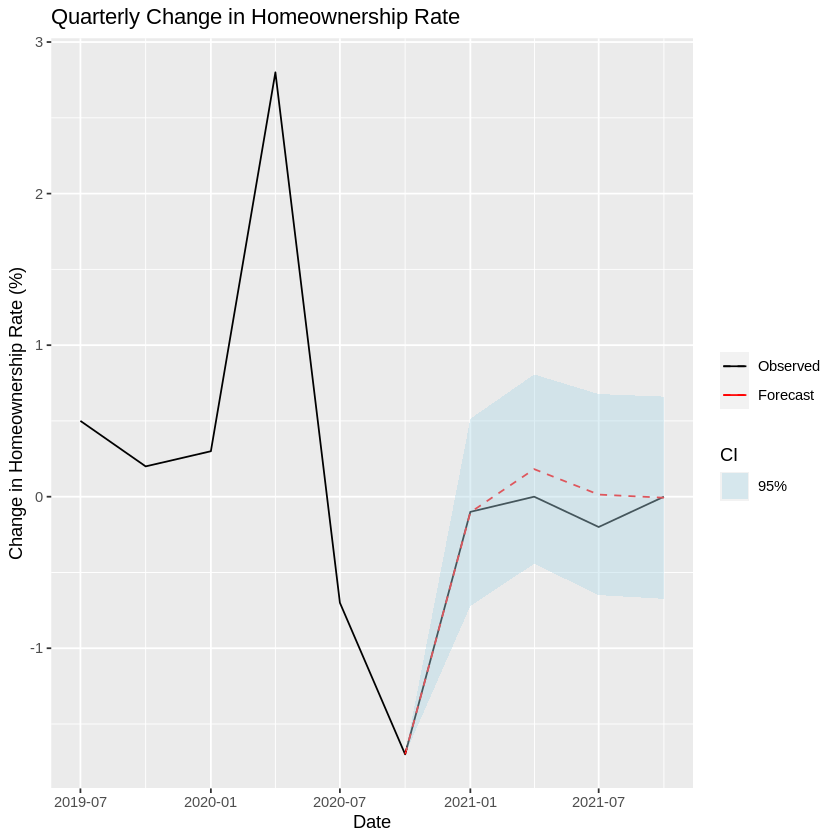

In [6]:
var_pred <- predict(var_model, n.ahead = 4, level = c(95))$fcst$homeownership %>% as.data.frame %>% dplyr::select(-CI)
connect <- as.data.frame(train)$homeownership %>% tail(1)
var_pred <- rbind(rep(connect, ncol(var_pred)), var_pred)
var_pred$Date <- c(tail(time(train),1), time(test))

data <- mvts %>% as.data.frame %>% rownames_to_column("Date")
data$Date <- as.Date(data$Date, format = "%Y-%m-%d")
data %>% tail(10) %>% ggplot() +
    geom_line(aes(x = Date, y = homeownership, color = "Observed")) +
    geom_line(data = var_pred, aes(x = Date, y = fcst, color = "Forecast"), linetype = "dashed") +
    geom_ribbon(data = var_pred, aes(x = Date, ymin = upper , ymax = lower, fill = "95%"), alpha = 0.4) +
    labs(x = "Date", y = "Change in Homeownership Rate (%)", title = "Quarterly Change in Homeownership Rate") +
    scale_color_manual("", values = c("Observed" = "black", "Forecast" = "red")) +
    scale_fill_manual("CI", values = c("95%" = "lightblue"))

In [7]:
accuracy(tail(var_pred, -1)$fcst, x = test$homeownership)
cat("PM = ", prec_measure(test$homeownership, tail(var_pred, -1)$fcst))

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.09642426,0.1404381,0.1014638,NaN,Inf


PM =  2.86878

### Undifferenced Reconstruction

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.2383674,0.28927,0.2400079,-0.3642719,0.3667726


PM = 8.367714

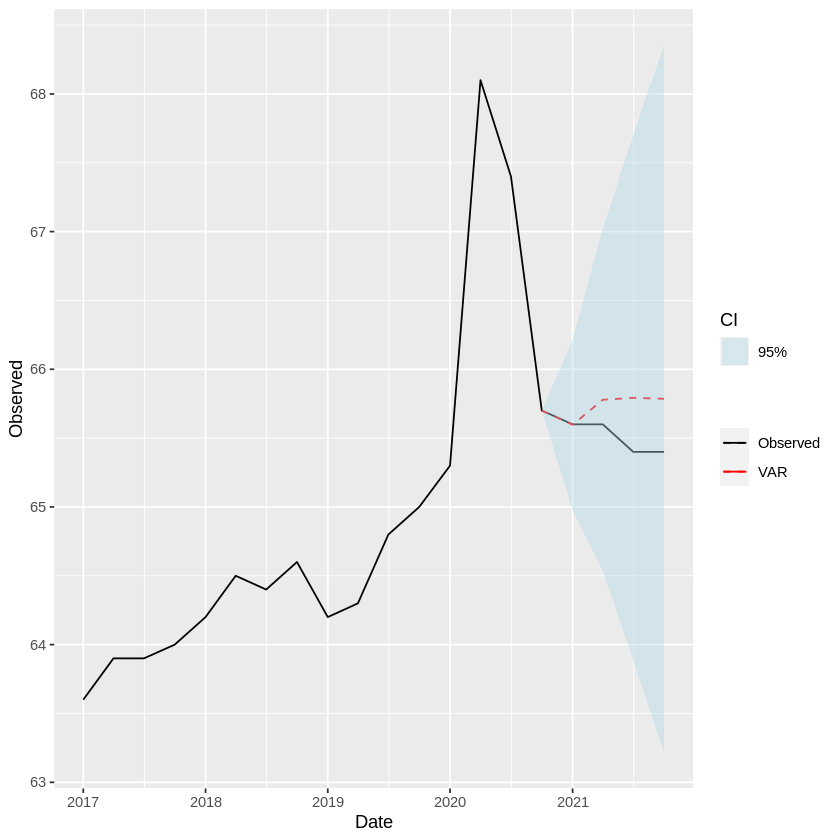

In [37]:
recon <- diffinv(c(ho_value, tail(var_pred$fcst, test_split)),
                       xi = homeownership_raw$Value[1])
upper <- diffinv(c(ho_value, tail(var_pred$upper, test_split)),
                       xi = homeownership_raw$Value[1])
lower <- diffinv(c(ho_value, tail(var_pred$lower, test_split)),
                       xi = homeownership_raw$Value[1])
combined_recon <- data.frame(Date = homeownership_raw$Date,
                            Observed = homeownership_raw$Value,
                            VAR = recon,
                            Upper = upper,
                            Lower = lower)

combined_recon %>% tail(20) %>% ggplot() +
    geom_line(aes(x = Date, y = Observed, color = "Observed")) +
    geom_line(data = tail(combined_recon, test_split + 1), aes(x = Date, y = VAR, color = "VAR"), linetype = "dashed") +
    geom_ribbon(data = tail(combined_recon, test_split + 1), aes(x = Date, ymin = Upper , ymax = Lower, fill = "95%"), alpha = 0.4) +
    scale_color_manual("", values = c("Observed" = "black", "VAR" = "red")) +
    scale_fill_manual("CI", values = c("95%" = "lightblue"))

fc_only <- tail(combined_recon, test_split)

accuracy(fc_only$VAR, x = fc_only$Observed)
cat("PM =", prec_measure(fc_only$Observed, fc_only$VAR))